# process the transient observations and set observation weights

In [1]:
%matplotlib inline
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu
import prep_deps
import redis
import matplotlib as mpl
plt.rcParams['font.size']=12
%matplotlib inline

flopy is installed in /Users/jwhite/Dev/gw1876/activities_stpete/notebooks/flopy


First we define a base directory `b_d` from which we will read in a model already created `freyberg.nam`. This will form the basis of the remainder of the exercise (and those to follow)

In [2]:
os.getcwd()

'/Users/jwhite/Dev/gw1876/activities_stpete/notebooks'

In [3]:
t_d = "template_history"
nam_file = "freyberg.nam"
pst_file = "freyberg.pst"
assert os.path.exists(t_d)

### load the existing Freyberg model. This version should run but is not yet connected with `PEST++`

In [4]:
# note that to load a model in a different folder, you supply the namefile without path and supply the path
# to it in the model_ws variable
m = flopy.modflow.Modflow.load(nam_file,model_ws=t_d,check=False,forgive=False)


### some visuals

/Users/jwhite/Dev/gw1876/activities_stpete/notebooks/flopy/plot/map.py:1415: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


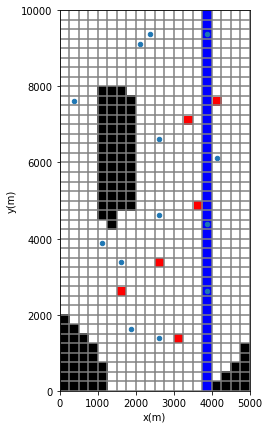

In [5]:
# plot some model attributes
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111,aspect="equal")
mm = flopy.plot.ModelMap(model=m)
mm.plot_grid()
mm.plot_ibound()
mm.plot_bc('SFR')
ax = mm.ax
#m.wel.stress_period_data.plot(ax=ax,mflay=2)

# plot obs locations
obs = pd.read_csv(os.path.join("..","base_model_files","obs_loc.csv"))
                  
obs_x = [m.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
obs_y = [m.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
ax.scatter(obs_x,obs_y,marker='.',label="water-level obs",s=80)

#plot names on the pumping well locations
wel_data = m.wel.stress_period_data[0]
wel_x = m.sr.xcentergrid[wel_data["i"],wel_data["j"]]
wel_y = m.sr.ycentergrid[wel_data["i"],wel_data["j"]]
for i,(x,y) in enumerate(zip(wel_x,wel_y)):
    ax.scatter([x],[y],color="red",marker="s",s=50)
    #ax.text(x,y,"{0}".format(i+1),ha="center",va="center")

ax.set_ylabel("y(m)")
ax.set_xlabel("x(m)")
plt.show()

### we can do a couple `flopy` things to move where the new model will be written

The next major task is to set the weights on the observations.  So far, in the `pst_helper` process, we simply identified what outputs from the model we want to "observe".  We now use a pre-cooked csv file to set nonzero weights only for GW level observation locations used in the original Freyberg model.  We will also use the SFR flow out of the last reach (`fo` in the last model row)

Set all weights to zero first, then turn on the weights at only a few locations.  These nonzero obs will be given meaningful weights in the prior monte carlo excercise

In [6]:
pst = pyemu.Pst(os.path.join(t_d,pst_file))
obs = pst.observation_data
obs.loc[:,"weight"] = 0.0

In [7]:
b_d = os.path.join("..","base_model_files")

In [8]:
obs_csv = os.path.join(b_d,"obs_data.csv")
assert os.path.exists(obs_csv)
obs_data = pd.read_csv(obs_csv,index_col=0,parse_dates=["datetime"])

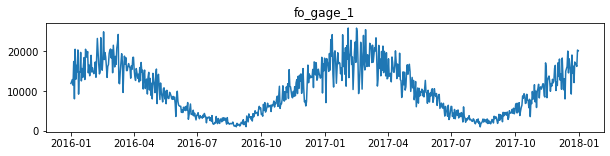

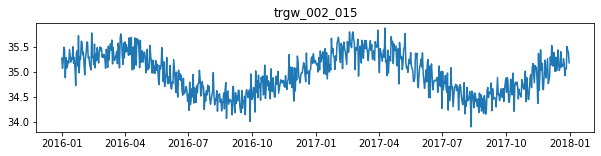

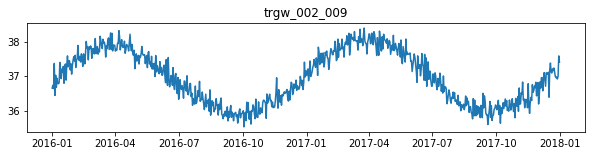

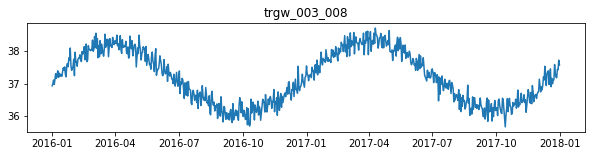

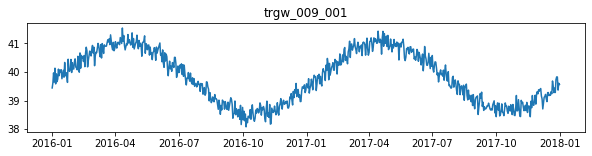

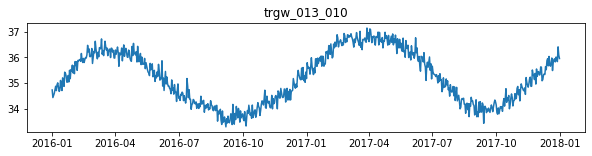

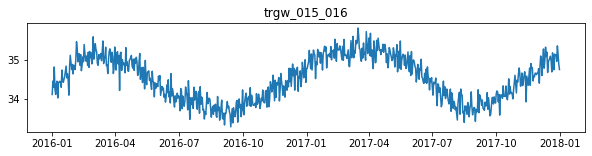

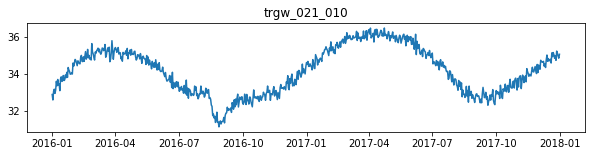

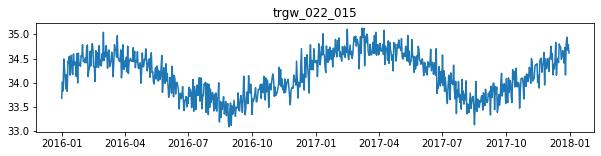

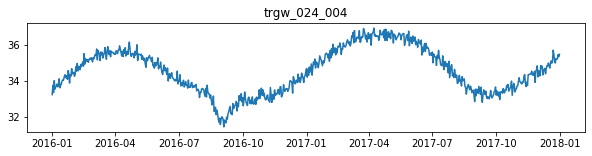

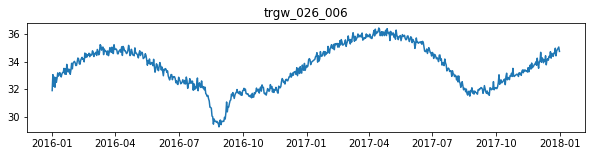

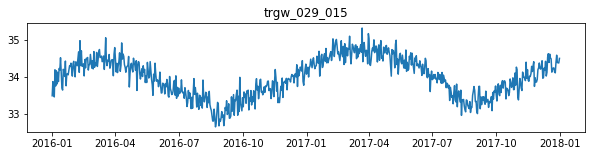

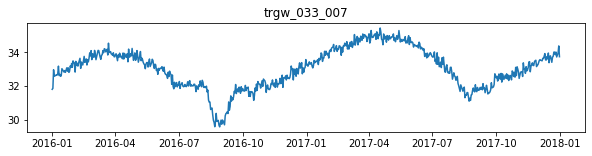

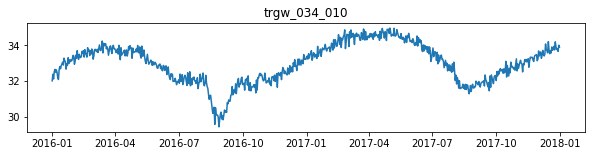

In [9]:
obs_sites = []
for site in pd.Series(obs_data.index.values).unique():
    site_obs_data = obs_data.loc[site,:]
    if len(site_obs_data.shape) == 1:
        continue
    obs_sites.append(site)
    #print(site,site_obs_data.shape)
    fig,ax = plt.subplots(1,1,figsize=(10,2))
    ax.plot(site_obs_data.datetime,site_obs_data.value)
    ax.set_title(site)
plt.show()

### Now we need to some how align these obs with the model stress periods...

In [10]:
sp_start = pd.to_datetime(m.start_datetime) + pd.to_timedelta(np.cumsum(m.dis.perlen.array),unit='d')

sp_end = sp_start - pd.to_timedelta(1.0,unit='d')
sp_start,sp_end

(DatetimeIndex(['2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
                '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
                '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
                '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
                '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
                '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
                '2018-01-01'],
               dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2015-12-31', '2016-01-31', '2016-02-29', '2016-03-31',
                '2016-04-30', '2016-05-31', '2016-06-30', '2016-07-31',
                '2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30',
                '2016-12-31', '2017-01-31', '2017-02-28', '2017-03-31',
                '2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31',
                '2017-08-31', '2017-09-30', '2017-10-31', '2017-11-30',
                '2017-12-31'],
               dtype='d

We have some choices to make now.  How do we align/sample the observations???

In [11]:
#just pick the nearest to the sp end
es_obs_data = []
for site in obs_sites:
    site_obs_data = obs_data.loc[site,:].copy()
    site_obs_data.loc[:,"site"] = site_obs_data.index.values
    site_obs_data.index = site_obs_data.datetime
    site_obs_data = site_obs_data.reindex(sp_start,method="nearest")
    
    if site_obs_data.shape != site_obs_data.dropna().shape:
        print("broke",site)
    es_obs_data.append(site_obs_data)
es_obs_data = pd.concat(es_obs_data,axis=0,ignore_index=True)
es_obs_data.shape

(350, 3)

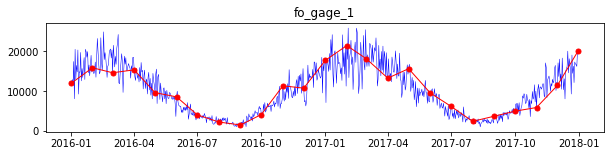

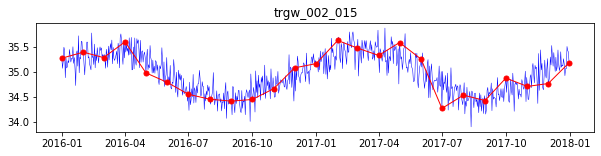

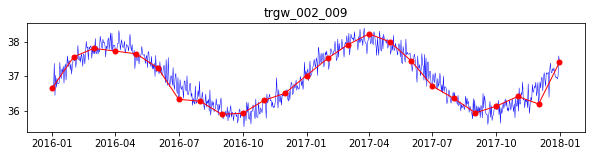

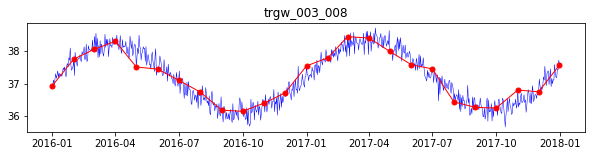

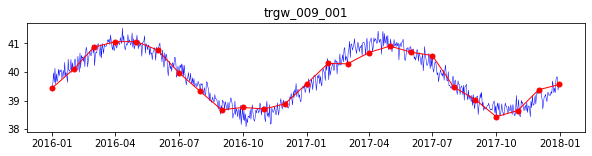

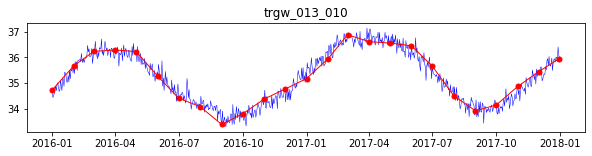

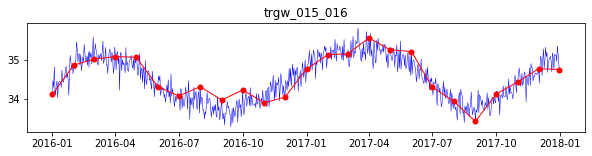

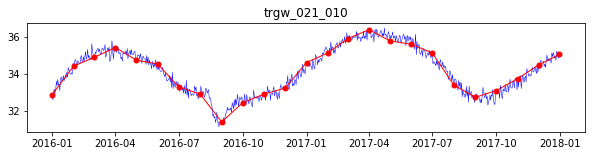

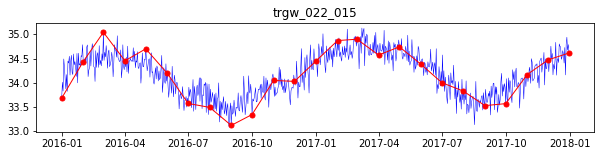

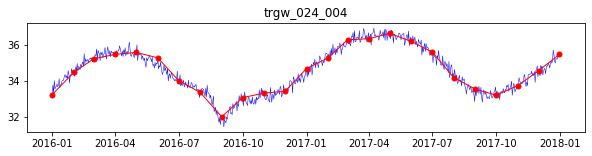

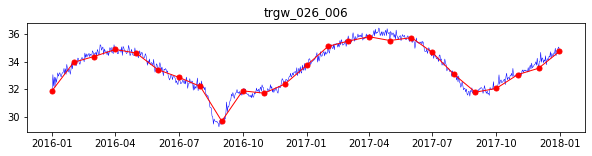

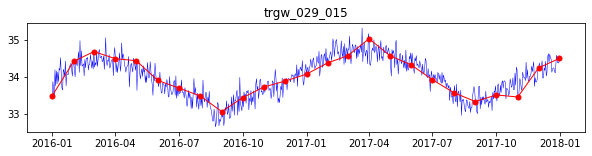

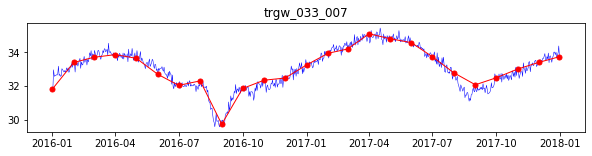

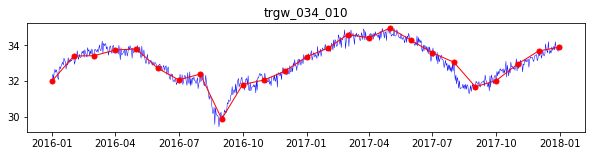

In [12]:
for site in obs_sites:
    #print(site)
    site_obs_data = obs_data.loc[site,:]
    es_site_obs_data = es_obs_data.loc[es_obs_data.site==site,:].copy()
    es_site_obs_data.sort_values(by="datetime",inplace=True)
    #print(site,site_obs_data.shape)
    fig,ax = plt.subplots(1,1,figsize=(10,2))
    ax.plot(site_obs_data.datetime,site_obs_data.value,"b-",lw=0.5)
    #ax.plot(es_site_obs_data.datetime,es_site_obs_data.value,'r-',lw=2)
    ax.plot(es_site_obs_data.datetime,es_site_obs_data.value,'r-',lw=1,marker='.',ms=10)
    ax.set_title(site)
plt.show()

Ruh roh - that isnt quite what we wanted:  we arent capturing the trend in the data very well.  

So, one approach is to run the obs thru a low-pass filter to strip out all those high freq components, then sample to stress period ends. Excel anyone?

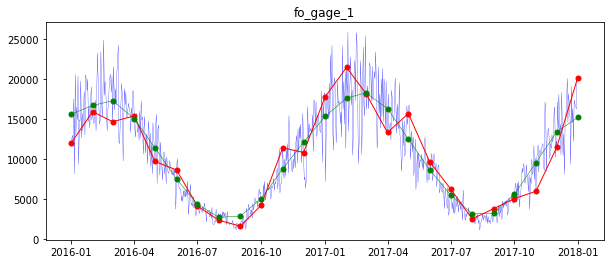

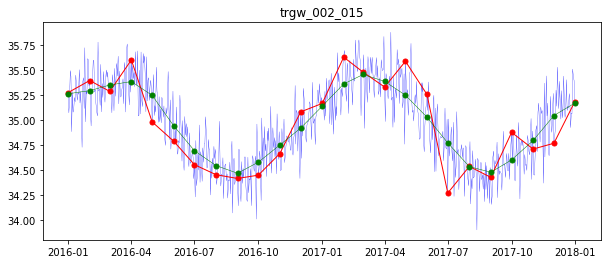

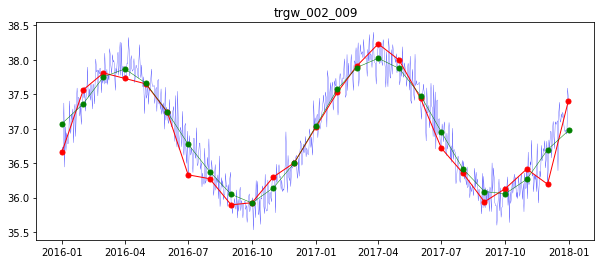

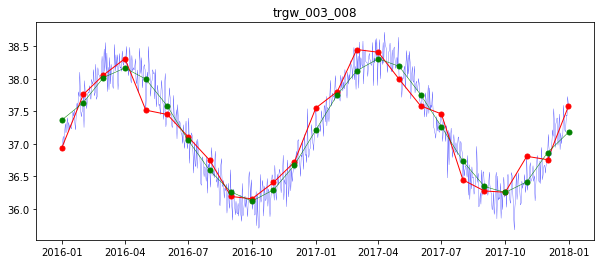

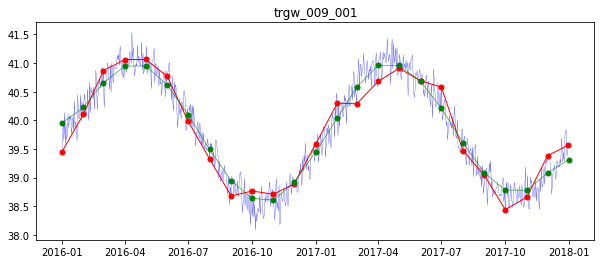

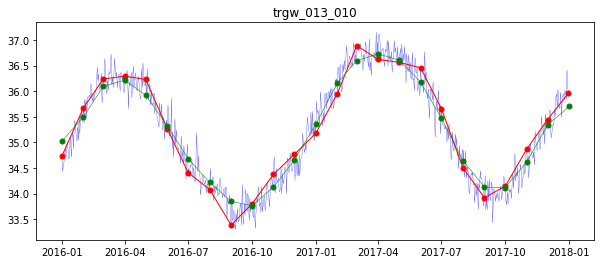

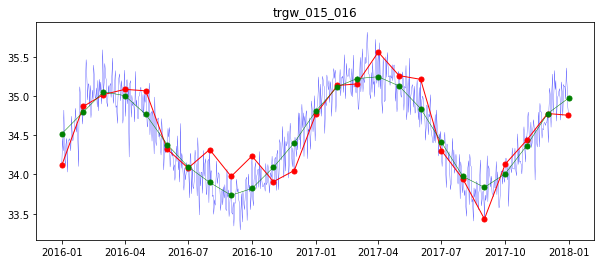

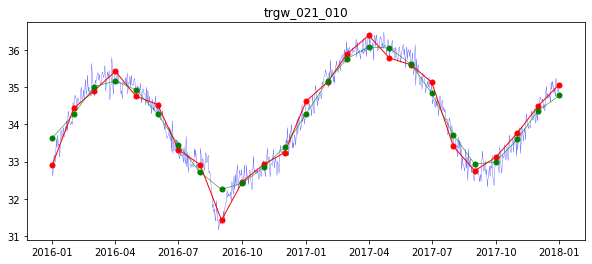

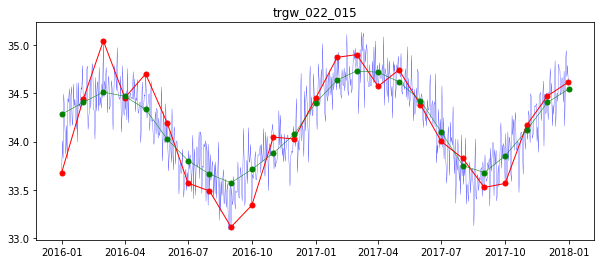

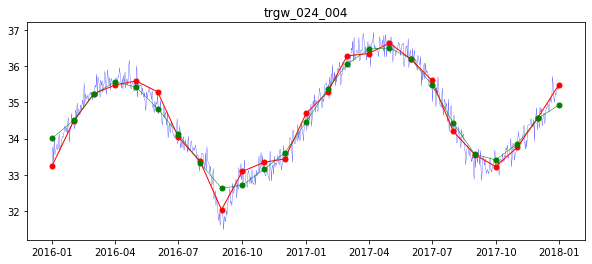

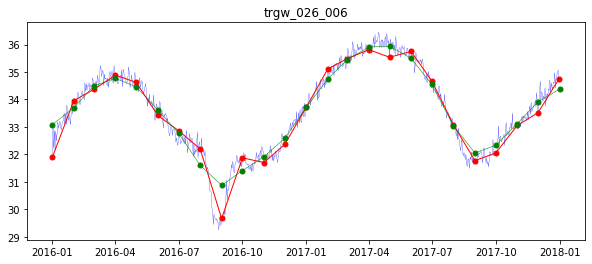

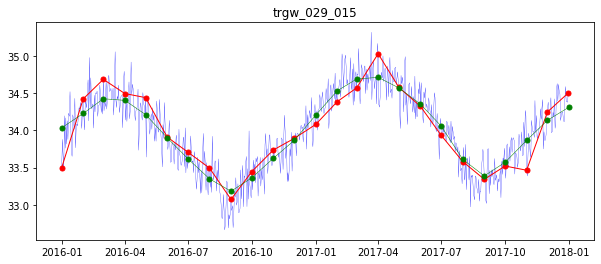

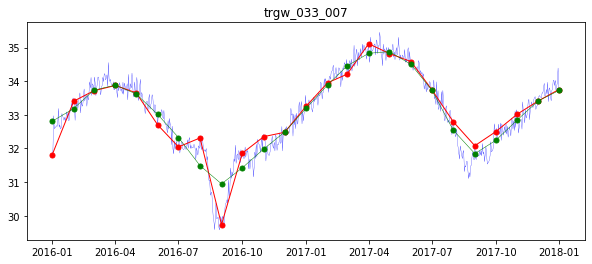

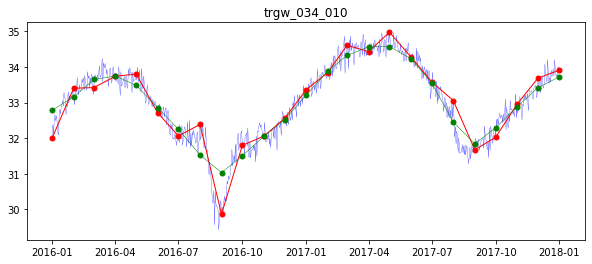

(25, 14)

In [33]:
ess_obs_data = {}
for site in obs_sites:
    #print(site)
    site_obs_data = obs_data.loc[site,:].copy()
    site_obs_data.loc[:,"site"] = site_obs_data.index.values
    site_obs_data.index = site_obs_data.datetime
    sm = site_obs_data.value.rolling(window=60,center=True,min_periods=1).mean()
    sm_site_obs_data = sm.reindex(sp_start,method="nearest")
    #ess_obs_data.append(pd.DataFrame9sm_site_obs_data)
    ess_obs_data[site] = sm_site_obs_data
    
    es_site_obs_data = es_obs_data.loc[es_obs_data.site==site,:].copy()
    es_site_obs_data.sort_values(by="datetime",inplace=True)
    fig,ax = plt.subplots(1,1,figsize=(10,4))
    ax.plot(site_obs_data.datetime,site_obs_data.value,"b-",lw=0.25)
    ax.plot(es_site_obs_data.datetime,es_site_obs_data.value,'r-',lw=1,marker='.',ms=10)
    ax.plot(sm_site_obs_data.index,sm_site_obs_data.values,'g-',lw=0.5,marker='.',ms=10)
    ax.set_title(site)
plt.show()
ess_obs_data = pd.DataFrame(ess_obs_data)
ess_obs_data.shape

Much better!  So now we need to get these smoothed-sampled obs values into the control file - yuck!

In [34]:
ess_obs_data.head()

,fo_gage_1,trgw_002_015,trgw_002_009,trgw_003_008,trgw_009_001,trgw_013_010,trgw_015_016,trgw_021_010,trgw_022_015,trgw_024_004,trgw_026_006,trgw_029_015,trgw_033_007,trgw_034_010
2016-01-01,15592.953209,35.265462,37.071573,37.366641,39.950810,35.021304,34.519625,33.637532,34.282303,34.008068,33.083260,34.033975,32.807557,32.786030
2016-02-01,16695.809330,35.296420,37.362724,37.635396,40.224168,35.496541,34.796436,34.266561,34.405881,34.503927,33.700493,34.225355,33.186090,33.158711
2016-03-01,17281.594724,35.352789,37.751698,38.020621,40.654835,36.096335,35.054214,35.008131,34.511557,35.225299,34.499865,34.423022,33.732865,33.651234
2016-04-01,15046.963840,35.387332,37.866838,38.168186,40.948411,36.212589,35.003394,35.163935,34.468677,35.568966,34.768692,34.401517,33.882782,33.747592
2016-05-01,11394.690791,35.249261,37.660974,37.996947,40.949567,35.919433,34.764707,34.924881,34.333891,35.420635,34.460134,34.209973,33.620825,33.484420


In [35]:
obs = pst.observation_data
obs.loc[:,"weight"] = 0.0
pset = set(pst.obs_names)
dt_str = ess_obs_data.index.map(lambda x: x.strftime("%Y%m%d")).values
for col in ess_obs_data.columns:
    obsnme = col+"_"+dt_str
    cset = set(obsnme)
    missing = cset - pset
    assert len(missing) == 0,missing
    obs.loc[obsnme,"obsval"] = ess_obs_data.loc[:,col].values
    obs.loc[obsnme,"weight"] = 1.0
print(pst.nnz_obs)
pst.nnz_obs_groups

350


['fo_gage_1',
 'trgw_002_015',
 'trgw_002_009',
 'trgw_003_008',
 'trgw_009_001',
 'trgw_013_010',
 'trgw_015_016',
 'trgw_021_010',
 'trgw_022_015',
 'trgw_024_004',
 'trgw_026_006',
 'trgw_029_015',
 'trgw_033_007',
 'trgw_034_010']

In [36]:
pst.write(os.path.join(t_d,pst_file))

noptmax:0, npar_adj:11873, nnz_obs:350


Run one last time.  `phi` should be substantial now since we now have "observed" value in the control file

In [37]:
pyemu.os_utils.run("pestpp-ies.exe {0}".format(pst_file),cwd=t_d)
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
pst.phi

103925289.13975662

woah - that's a big phi

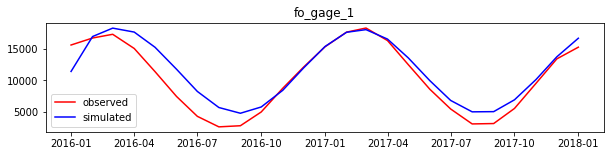

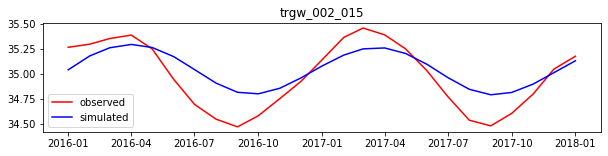

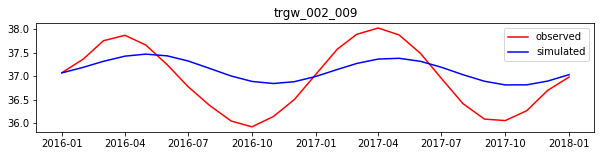

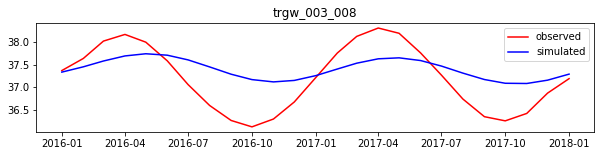

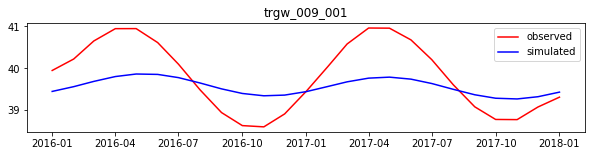

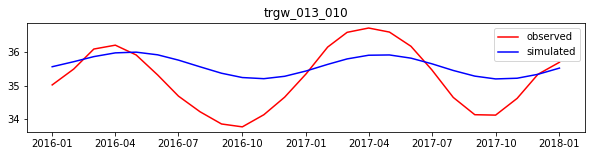

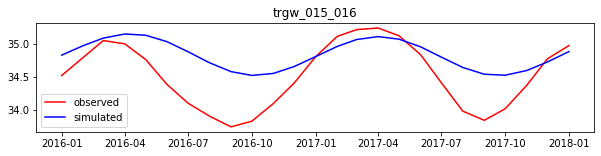

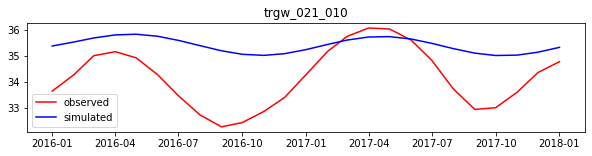

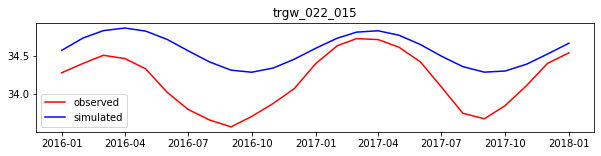

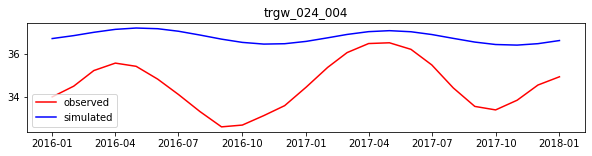

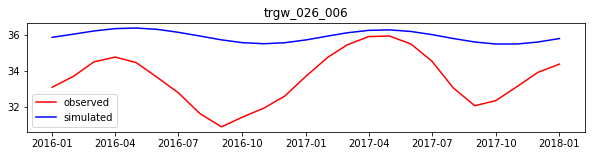

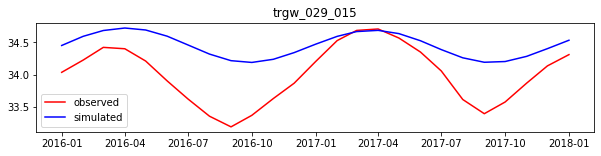

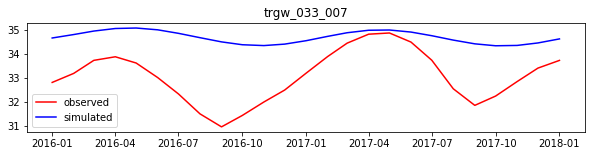

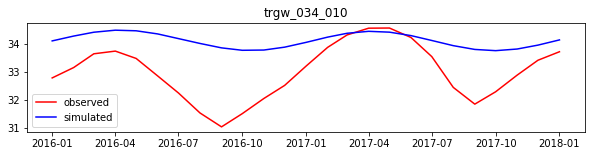

In [38]:
nz_obs = pst.observation_data.loc[pst.nnz_obs_names,:].copy()
nz_obs.loc[:,"datetime"] = pd.to_datetime(nz_obs.obsnme.apply(lambda x: x.split("_")[-1]))    
for nz_group in pst.nnz_obs_groups:
    nz_obs_group = nz_obs.loc[nz_obs.obgnme==nz_group,:]
    fig,ax = plt.subplots(1,1,figsize=(10,2))
    ax.plot(nz_obs_group.datetime,nz_obs_group.obsval,"r-",label="observed")
    ax.plot(nz_obs_group.datetime,pst.res.loc[nz_obs_group.obsnme,"modelled"],"b-",label="simulated")
    ax.set_title(nz_group)
    ax.legend()
plt.show()

Here are the non-zero weighted observation contributions to phi


<Figure size 432x288 with 0 Axes>

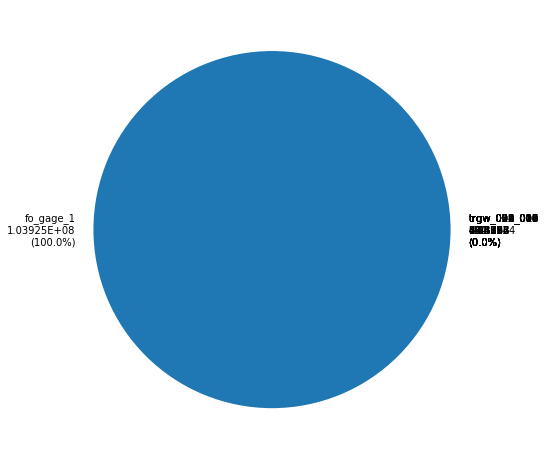

<Figure size 576x756 with 0 Axes>

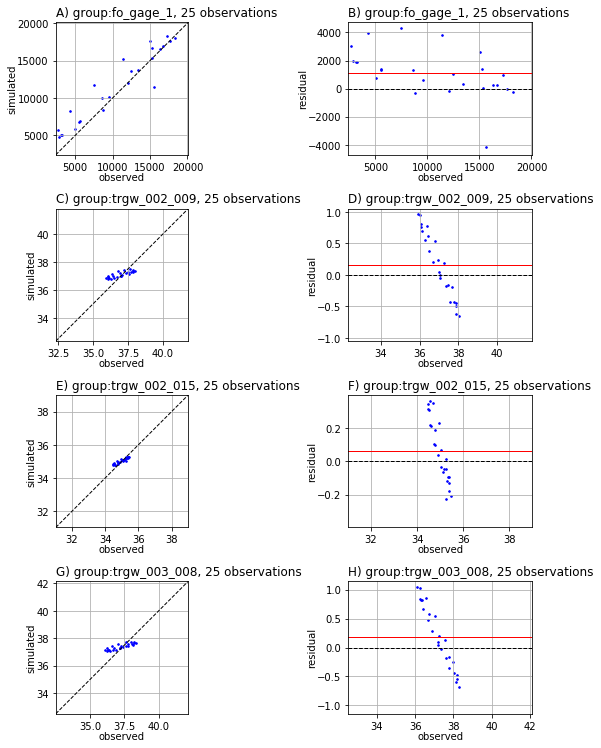

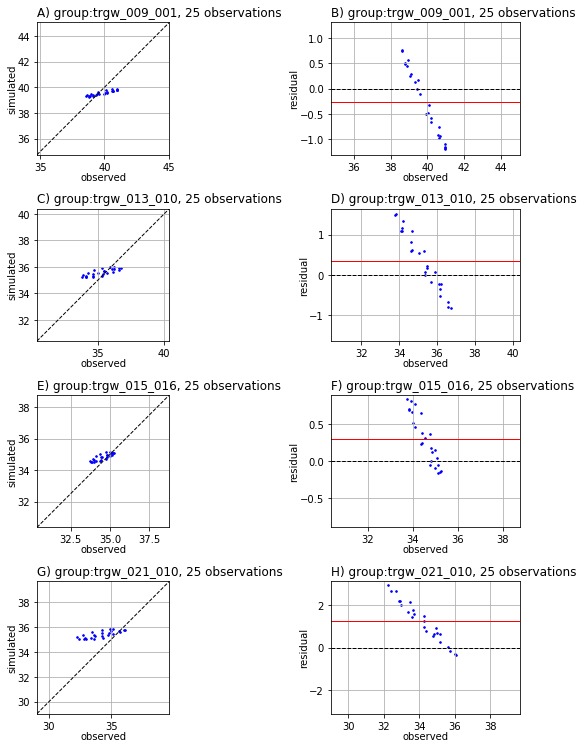

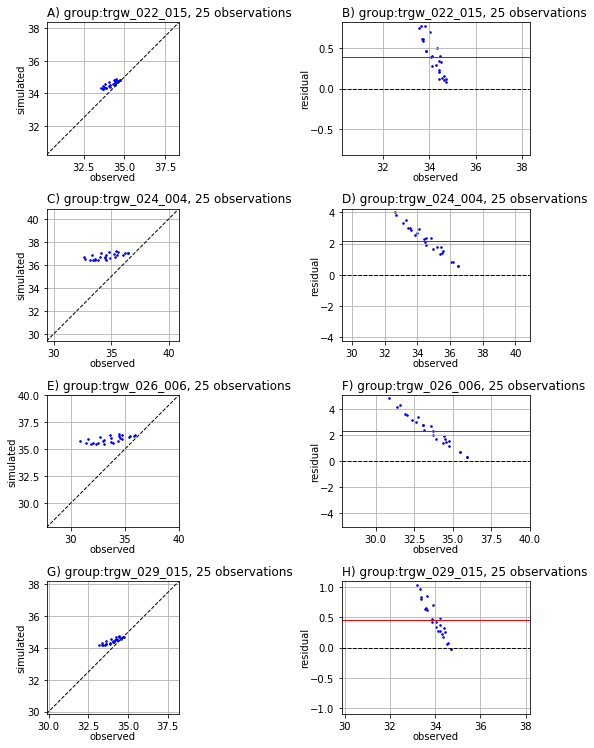

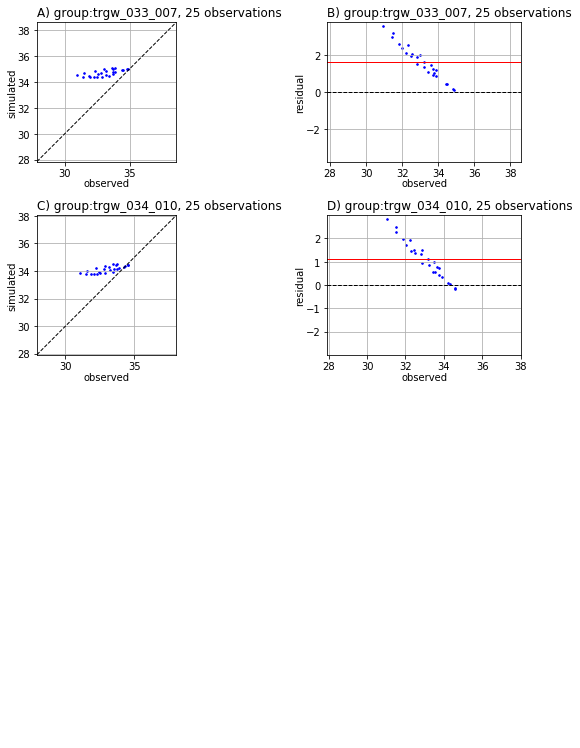

In [39]:
plt.figure()
pst.plot(kind='phi_pie');
print('Here are the non-zero weighted observation contributions to phi')

figs = pst.plot(kind="1to1");
pst.res.loc[pst.nnz_obs_names,:]
plt.show()

Clearly not what we want...let's try error-based weighting combined with common sense (e.g. subjectivity)


Here are the non-zero weighted observation contributions to phi


<Figure size 432x288 with 0 Axes>

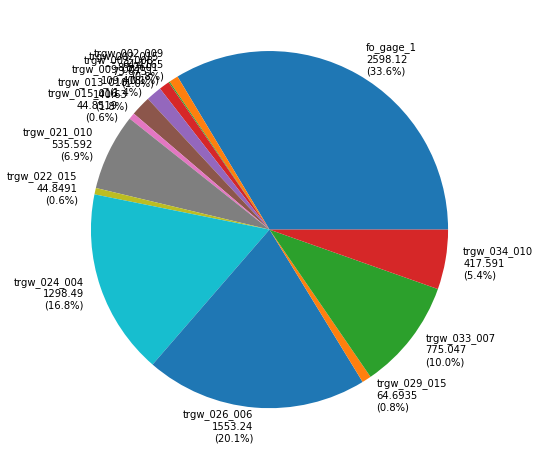

<Figure size 576x756 with 0 Axes>

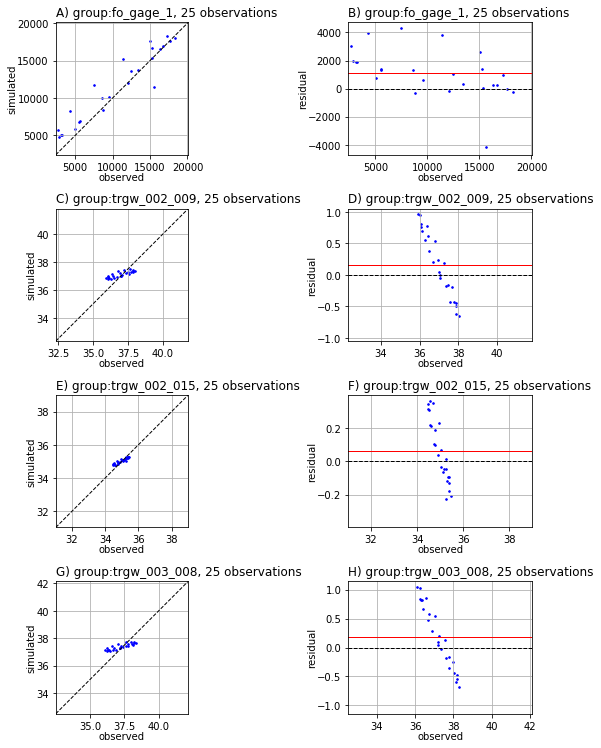

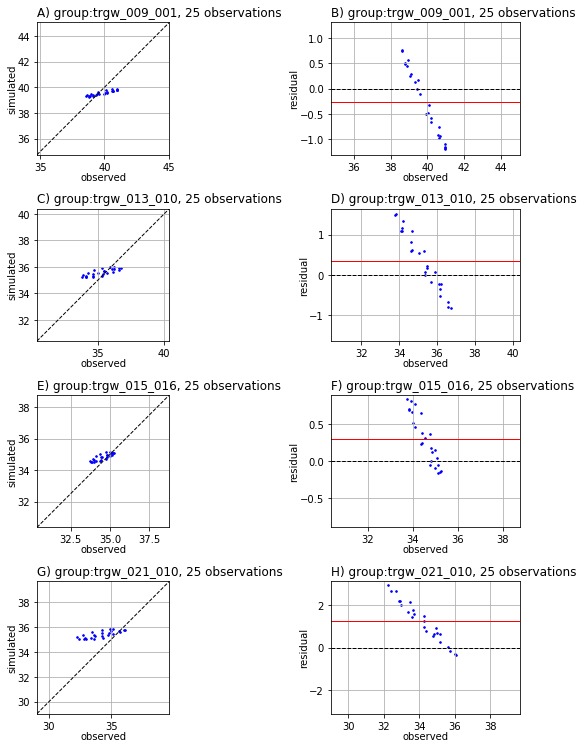

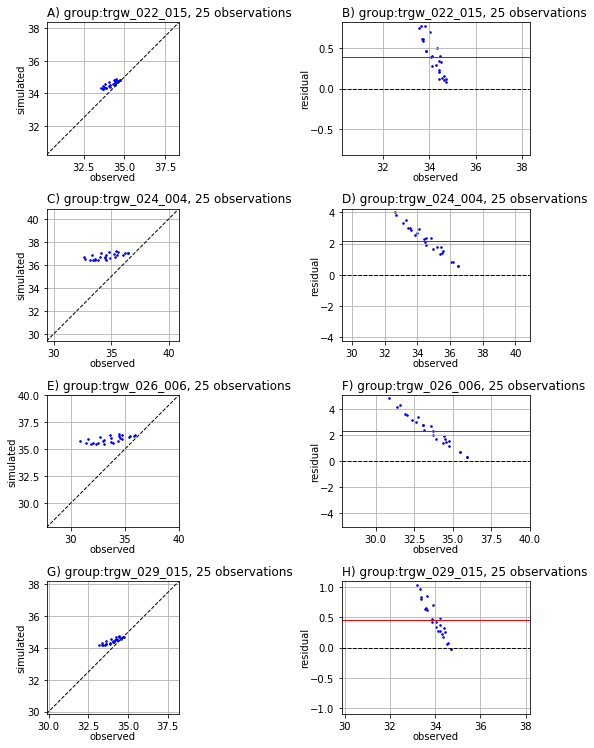

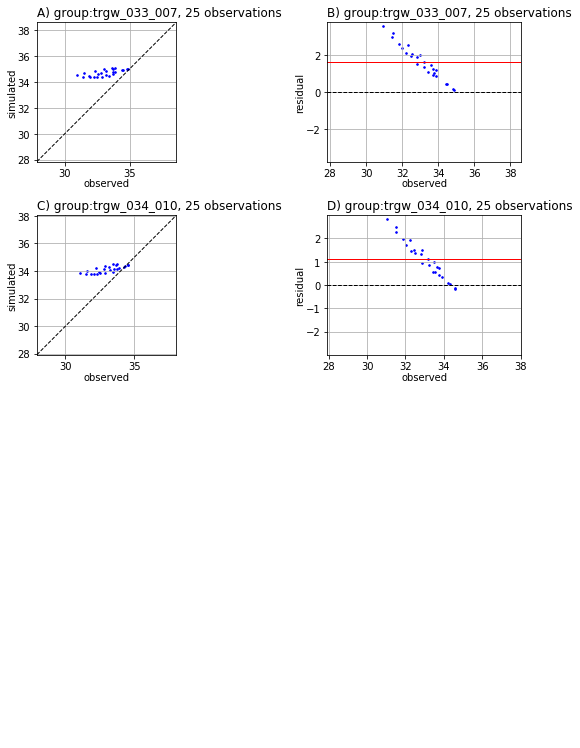

In [53]:
nz_obs = pst.observation_data.loc[pst.nnz_obs_names,:]
trgw_obs = nz_obs.loc[nz_obs.obgnme.apply(lambda x: x.startswith("trgw")),:]
pst.observation_data.loc[trgw_obs.obsnme,"weight"] = 3.0
fo_obs = nz_obs.loc[nz_obs.obgnme.apply(lambda x: x.startswith("fo_")),:]
# fanciness alert: heteroskedasticity
#pst.observation_data.loc[fo_obs.obsnme,"weight"] = 1.0 / (fo_obs.obsval * .2)
pst.observation_data.loc[fo_obs.obsnme,"weight"] = 0.005
print()
plt.figure()
pst.plot(kind='phi_pie');
print('Here are the non-zero weighted observation contributions to phi')

figs = pst.plot(kind="1to1");
pst.res.loc[pst.nnz_obs_names,:]
plt.show()

### Ok, thats better...

In [54]:
pst.write(os.path.join(t_d,pst_file))

noptmax:0, npar_adj:11873, nnz_obs:350


### Discussion:  since we want to forecast low-flow/low-water level things, should we "target" low-flow/low-water level observations? What are the implications of a "targeted" approach?  How do you do that?

## Understanding weights and measurement noise in the context of parameter estimation

Now let's visualize what these weights actually imply:

In [55]:
oe = pyemu.ObservationEnsemble.from_gaussian_draw(pst=pst,num_reals=100)

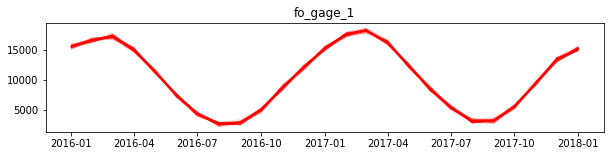

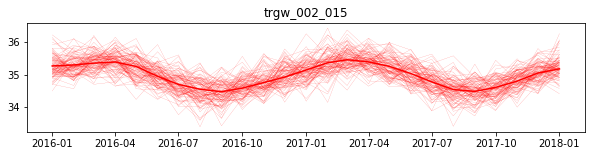

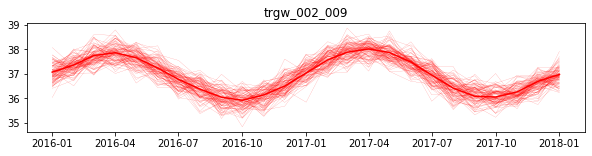

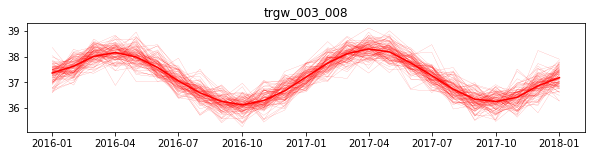

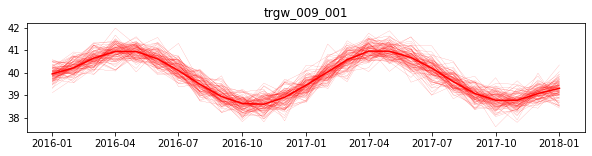

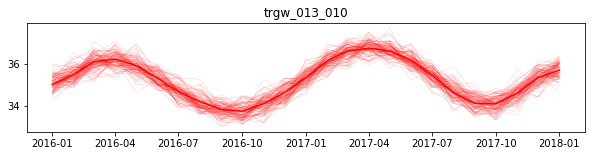

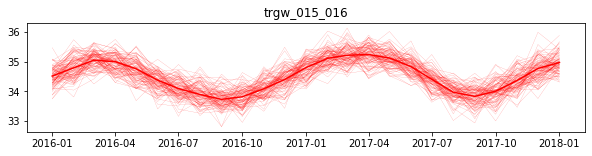

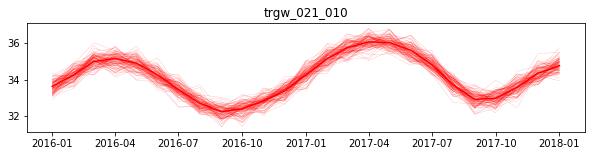

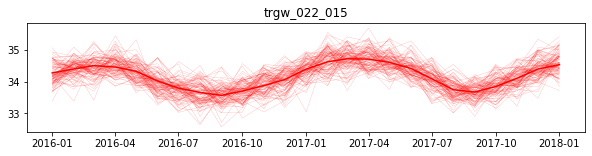

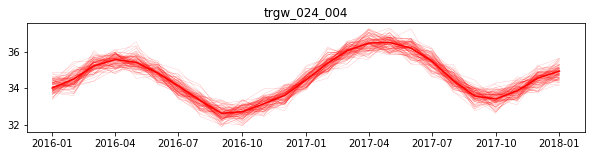

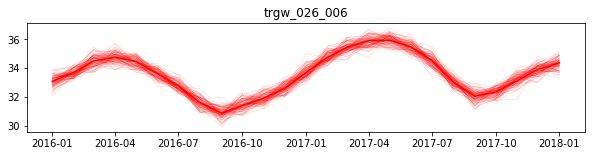

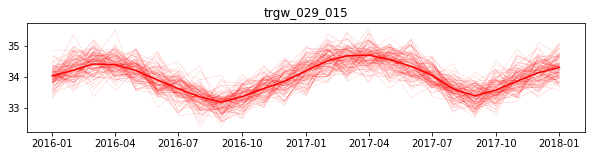

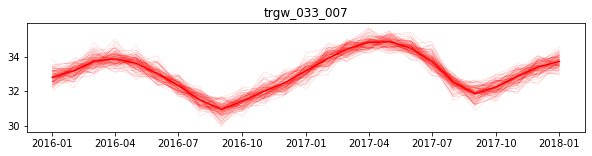

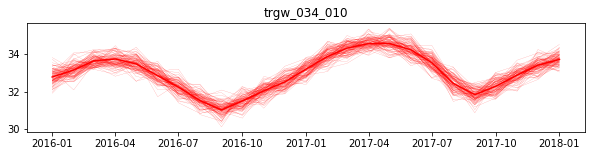

In [56]:
nz_obs = pst.observation_data.loc[pst.nnz_obs_names,:].copy()
nz_obs.loc[:,"datetime"] = pd.to_datetime(nz_obs.obsnme.apply(lambda x: x.split("_")[-1]))
pst_base = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
for nz_group in pst.nnz_obs_groups:
    nz_obs_group = nz_obs.loc[nz_obs.obgnme==nz_group,:]
    fig,ax = plt.subplots(1,1,figsize=(10,2))
    
    [ax.plot(nz_obs_group.datetime,oe.loc[r,nz_obs_group.obsnme],color="r",lw=0.1) for r in oe.index]
    ax.plot(nz_obs_group.datetime,nz_obs_group.obsval,"r-")
    ax.set_title(nz_group)
    #vmin = min(nz_obs_group.obsval.min(),oe_pt.loc[:,nz_obs_group.obsnme].min().min())
    #vmax = max(nz_obs_group.obsval.max(),oe_pt.loc[:,nz_obs_group.obsnme].max().max())
plt.show()

What we are saying with these weights is that any one of these red traces could have also be "observed" or "measured".  Are we happy with these?

### An aside on generating autocorrelated transient noise...

In [57]:
v = pyemu.geostats.ExpVario(a=30,contribution=1.0)
x = np.arange(m.nper)
y = np.zeros_like(x)
names = ["obs_{0}".format(xx) for xx in x]
cov = v.covariance_matrix(x,y,names=names)

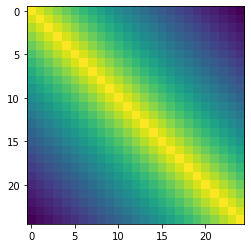

In [45]:
plt.imshow(cov.x)

In [46]:
df = pd.DataFrame(np.NaN,index=nz_obs.obsnme,columns=nz_obs.obsnme)

In [47]:
for nz_group in pst.nnz_obs_groups:
    nz_obs_group = nz_obs.loc[nz_obs.obgnme==nz_group,:]
    x_group = cov.x.copy()
    w = nz_obs_group.weight.mean()
    v = (1./w)**2
    x_group *= v
    df.loc[nz_obs_group.obsnme,nz_obs_group.obsnme] = x_group

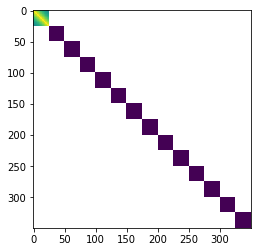

In [48]:
plt.imshow(df.values)

In [49]:
cov = pyemu.Cov.from_dataframe(df)

In [50]:
oe_corr = pyemu.ObservationEnsemble.from_gaussian_draw(pst=pst,cov=cov,num_reals=100)

drawing from group fo_gage_1
drawing from group trgw_002_009
drawing from group trgw_002_015
drawing from group trgw_003_008
drawing from group trgw_009_001
drawing from group trgw_013_010
drawing from group trgw_015_016
drawing from group trgw_021_010
drawing from group trgw_022_015
drawing from group trgw_024_004
drawing from group trgw_026_006
drawing from group trgw_029_015
drawing from group trgw_033_007
drawing from group trgw_034_010


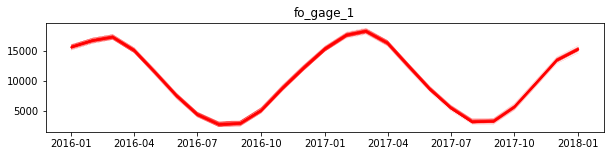

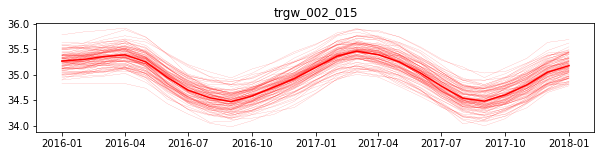

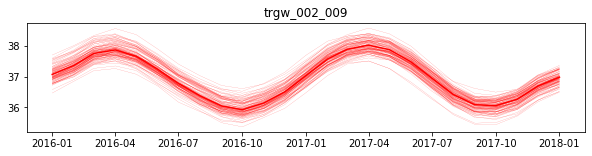

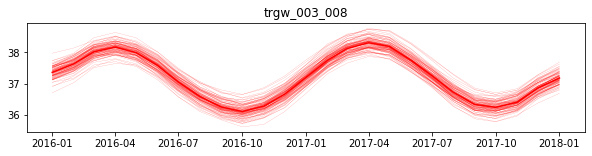

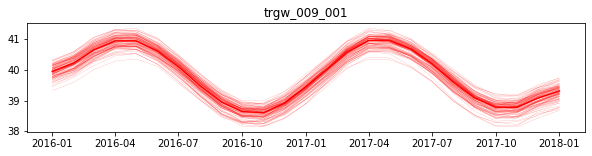

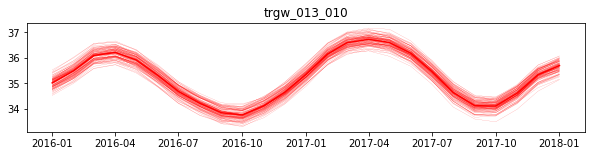

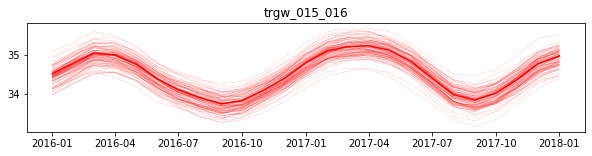

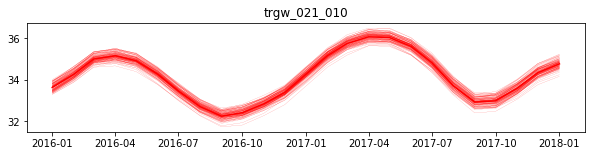

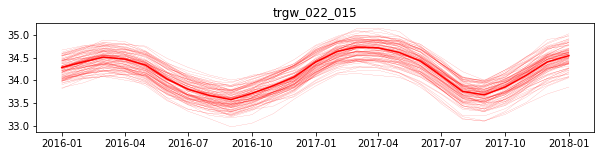

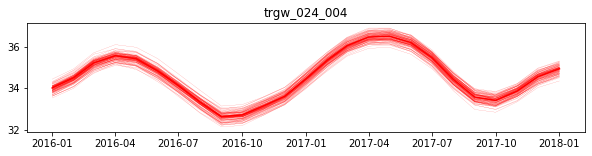

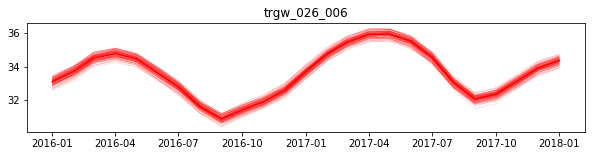

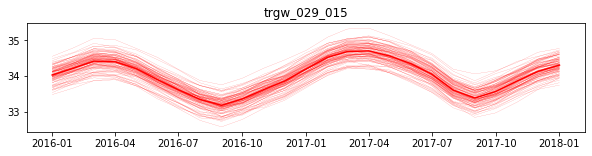

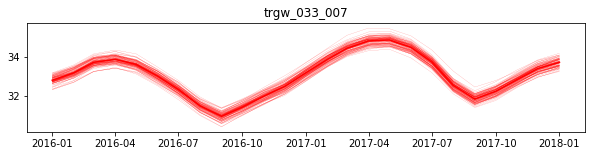

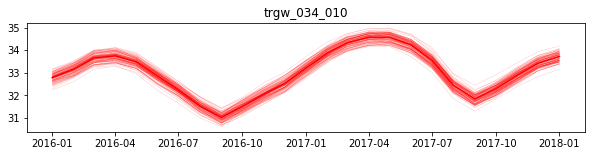

In [51]:
nz_obs = pst.observation_data.loc[pst.nnz_obs_names,:].copy()
nz_obs.loc[:,"datetime"] = pd.to_datetime(nz_obs.obsnme.apply(lambda x: x.split("_")[-1]))
for nz_group in pst.nnz_obs_groups:
    nz_obs_group = nz_obs.loc[nz_obs.obgnme==nz_group,:]
    fig,ax = plt.subplots(1,1,figsize=(10,2))
    
    [ax.plot(nz_obs_group.datetime,oe_corr.loc[r,nz_obs_group.obsnme],color="r",lw=0.1) for r in oe_corr.index]
    ax.plot(nz_obs_group.datetime,nz_obs_group.obsval,"r-")
    ax.set_title(nz_group)
    #vmin = min(nz_obs_group.obsval.min(),oe_pt.loc[:,nz_obs_group.obsnme].min().min())
    #vmax = max(nz_obs_group.obsval.max(),oe_pt.loc[:,nz_obs_group.obsnme].max().max())
plt.show()

### How often do we specify noise models like this???

In [52]:
cov.x[np.isnan(cov.x)] = 0.0
cov.to_coo(os.path.join(t_d,"obs_cov.jcb"))